In [0]:
from functools import reduce
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # standard graphics
import seaborn as sns # fancier graphics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [0]:
#Setting up Spark environment
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
from google.colab import files
uploaded = files.upload()

Saving carwood.csv to carwood (2).csv


In [0]:
df = pd.read_csv('carwood.csv')

In [7]:
df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,label
0,170.39,167.28,143.44,124.67,139.01,125.83,144.33,151.26,175.51,171.31,161.90,146.92,141.80,140.91,132.80,128.48,170.83,161.06,169.61,168.07,154.88,149.33,152.91,152.61,137.09,169.59,183.01,180.44,164.55,152.63,157.77,165.07,149.52,142.73,173.85,182.23,174.58,163.28,164.01,169.20,148.48,134.31,174.07,191.33,157.51,168.66,156.89,170.86,162.24,184.84,167.02,123.67,140.54,153.69,147.57,144.65,162.24,172.96,169.67,157.51,161.06,133.23,124.41,138.44,142.93,137.13,134.44,0
1,169.75,190.96,175.53,138.27,137.47,139.23,133.23,130.25,147.73,163.93,167.36,171.52,155.54,139.34,151.95,149.30,173.37,141.00,153.57,128.45,159.93,165.33,147.94,143.74,140.88,182.53,184.08,148.09,125.26,139.67,138.70,132.86,141.50,145.40,164.58,170.71,127.83,133.99,141.20,152.87,142.36,148.26,162.54,156.55,153.39,137.99,129.64,137.59,155.39,147.92,152.14,162.48,168.72,161.14,147.87,141.02,155.39,139.58,141.58,153.39,141.00,148.43,168.12,169.90,165.64,166.86,137.69,0
2,153.69,153.68,144.02,158.73,178.87,157.04,152.92,147.52,142.87,165.26,160.39,137.86,149.62,153.43,152.60,162.85,146.35,167.11,134.27,126.81,136.28,158.40,171.58,161.60,162.91,143.14,129.73,125.97,151.09,177.89,169.20,160.65,156.86,135.66,126.92,131.22,154.37,158.59,158.52,155.25,154.33,130.18,127.66,148.94,155.37,163.53,139.70,143.79,141.61,166.88,164.60,149.58,139.56,154.74,173.01,155.18,141.61,155.19,170.51,155.37,167.11,146.89,141.01,159.43,169.68,163.24,165.17,0
3,131.69,151.56,151.05,134.00,151.18,175.53,171.34,159.77,151.95,146.10,148.53,140.28,138.16,145.44,150.40,158.18,163.80,152.43,171.49,150.20,131.28,157.18,157.04,151.13,151.66,143.32,157.23,152.91,134.75,154.65,171.65,160.30,157.73,143.67,145.87,151.73,147.09,151.21,157.96,148.50,156.60,147.45,153.18,156.58,157.83,147.98,143.47,142.83,138.08,147.91,148.05,145.66,156.50,167.52,151.33,129.51,138.08,164.25,155.82,157.83,152.43,150.82,146.58,128.85,140.76,177.35,174.61,0
4,162.85,158.88,132.27,138.41,143.98,159.30,177.26,180.58,159.34,164.66,138.04,132.76,157.88,165.58,173.64,163.50,127.97,167.31,141.39,147.02,137.52,135.46,146.41,159.09,164.53,148.45,130.76,136.22,144.86,127.38,137.09,159.08,153.25,182.49,187.75,139.37,117.12,124.07,134.60,144.85,132.64,170.87,188.26,173.32,135.74,127.15,131.69,127.80,149.46,114.16,100.11,154.02,175.30,175.46,144.39,142.47,149.46,132.80,130.96,135.74,167.31,188.21,179.52,146.20,153.73,152.12,146.58,0


In [8]:
#Checking dimension(features, observations)
#The number of features is less than observations. 
#Therefore, I consider it as a low dimensional dataset.
df.shape

(2048, 68)

In [9]:
#dataset is complete
missing_data = df.isnull().sum()
missing_data.head()

f1    0
f2    0
f3    0
f4    0
f5    0
dtype: int64

In [10]:
#According to the properties (mean, meadian, min, max, etc.) it should be claimed statistical results and range are similar
df.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,label
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,125.569231,125.356807,125.422041,125.719333,126.005055,126.084465,125.885123,125.783833,125.704766,125.858361,125.394845,125.674087,126.013817,126.071018,125.905548,125.649362,125.720607,124.636116,125.925467,125.672095,125.626894,126.120828,126.452329,126.030681,125.938922,125.436985,125.642772,125.350434,125.153424,125.588723,125.862603,125.777101,126.114360,124.802756,125.485349,125.100847,124.529527,124.959006,125.344213,125.352716,125.322815,124.368897,124.494701,124.379704,124.988847,124.212635,124.015511,124.239888,125.054577,124.726197,124.851752,124.681799,124.554998,124.788285,124.988186,124.724497,125.054577,125.262919,125.201682,124.988847,124.636116,124.841744,125.067299,125.202800,125.444424,125.414388,125.564611,0.501465
std,33.292731,32.822212,32.643005,32.966031,33.526247,33.589233,33.220224,33.214697,33.548514,33.402901,32.788323,33.139636,33.596940,33.649753,33.395156,33.117749,32.821256,33.203148,33.194239,32.860294,32.889931,33.358334,33.539194,33.257714,32.945501,33.519881,33.437336,32.970900,32.758562,33.246426,33.531668,33.483145,33.632709,33.249019,33.590801,33.247055,32.476556,32.908790,33.366125,33.495895,33.304360,33.889958,33.748150,33.668510,33.527471,33.738985,33.501672,33.634354,33.813020,33.951207,33.918297,33.481712,33.492443,33.765211,34.105339,33.741519,33.813020,34.030045,33.795493,33.527471,33.203148,33.230530,33.728213,33.685539,33.716557,33.675680,33.669027,0.500120
min,47.124000,47.262000,48.485000,49.323000,47.077000,47.365000,47.063000,47.546000,49.302000,48.393000,48.001000,49.138000,51.571000,51.154000,48.043000,47.507000,42.081000,47.444000,44.227000,48.473000,48.780000,50.101000,50.896000,49.030000,49.496000,45.491000,48.195000,47.260000,46.670000,44.992000,45.669000,46.245000,45.589000,46.734000,45.279000,42.499000,45.096000,44.383000,43.993000,43.201000,46.362000,43.346000,44.097000,42.936000,49.456000,45.339000,45.733000,43.998000,40.721000,40.565000,43.186000,41.958000,43.798000,44.526000,42.369000,42.543000,40.721000,45.416000,47.957000,49.456000,47.444000,45.266000,44.772000,46.018000,47.871000,50.691000,53.071000,0.000000
25%,99.490000,99.095500,100.217500,99.784750,99.094250,98.990500,99.144750,99.745750,98.876750,99.449500,99.277500,98.952000,99.036250,98.669250,99.077000,99.552000,99.955250,99.410750,100.041250,100.622500,100.737500,100.417500,100.397500,100.092500,100.412500,99.851000,99.654000,100.122500,100.177500,99.898750,99.795000,100.127500,100.182500,99.350000,99.867500,100.380000,100.265000,100.080000,100.065000,100.045000,100.257500,100.485000,100.060000,100.445000,100.001750,100.170000,100.257500,100.285000,100.915000,100.590000,100.727500,100.692500,100.627500,100.562500,100.977500,100.630000,100.915000,100.787500,100.782500,100.001750,99.410750,99.743250,99.723250,99.964250,100.127500,100.280000,100.590000,0.000000
50%,123.430000,124.160000,123.970000,124.460000,123.735000,124.275000,12

**Checking scalability**

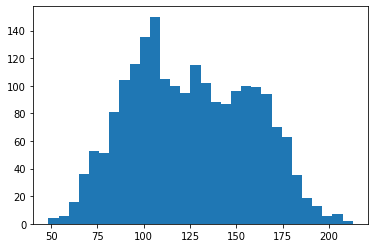

In [11]:
plt.hist(df['f3'], bins=30)
plt.show()

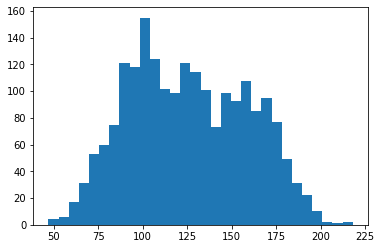

In [12]:
plt.hist(df['f7'], bins=30)
plt.show()

The features such as f3 and f7 have the same units and scales.

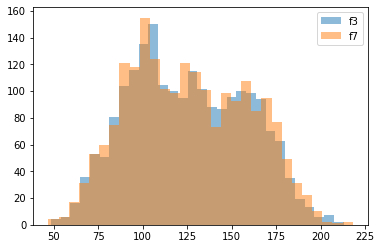

In [13]:
f3 = [df['f3']]
f7 = [df['f7']]
plt.hist(f3, alpha=0.5, label='f3', bins=30)
plt.hist(f7, alpha=0.5, label='f7', bins=30)
plt.legend(loc='upper right')
plt.show()

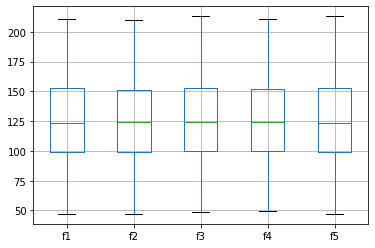

In [14]:
df.boxplot(column = ['f1', 'f2', 'f3', 'f4', 'f5'])

This histogram proves the previous claim and enforces the idea that there is no need for extra action such as normalization or standardization.

In [0]:
#Finding duplicate columns
def DuplicateColumn(df):
    DuplicateColumns= set()
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            others = df.iloc[:, y]
            if col.equals(others):
                DuplicateColumns.add(df.columns.values[y])
 
    return list(DuplicateColumns)

In [0]:
my_duplicates = DuplicateColumn(df)

In [17]:
print('Please find duplicate columns:')
for col in my_duplicates:
    print('Column name : ', col)

Please find duplicate columns:
Column name :  f57
Column name :  f60
Column name :  f61


In [18]:
# Deleting duplicate columns
new_df = df.drop(columns=DuplicateColumn(df))
 
print("New dataframe", new_df, sep='\n')

New dataframe
           f1       f2       f3       f4  ...      f65      f66      f67  label
0     170.390  167.280  143.440  124.670  ...  142.930  137.130  134.440      0
1     169.750  190.960  175.530  138.270  ...  165.640  166.860  137.690      0
2     153.690  153.680  144.020  158.730  ...  169.680  163.240  165.170      0
3     131.690  151.560  151.050  134.000  ...  140.760  177.350  174.610      0
4     162.850  158.880  132.270  138.410  ...  153.730  152.120  146.580      0
...       ...      ...      ...      ...  ...      ...      ...      ...    ...
2043   98.263  100.060   98.223   95.452  ...   74.998   76.695   78.166      1
2044   75.507   73.811   73.184   72.460  ...   61.225   58.836   61.005      1
2045   97.784  101.720   99.211   99.763  ...  113.940  113.270  120.430      1
2046  119.330  118.820  119.030  118.250  ...  109.400  108.970  109.590      1
2047  109.510  108.060  106.520  109.350  ...  113.660  107.080  103.280      1

[2048 rows x 65 columns]


In [0]:
#checking duplicates in new df
my_duplicates_new = DuplicateColumn(new_df)

In [20]:
#No duplicates
print('No duplicate columns')
for col in my_duplicates_new:
    print('Column name : ', col)

No duplicate columns


In [21]:
new_df['label'].value_counts()

1    1027
0    1021
Name: label, dtype: int64

In [0]:
#Above given results show that it is imbalanced data

In [0]:
# Training model on imbalanced data
# Creating X, y features
y = new_df.label
X = new_df.drop('label', axis=1)
 
# Train model
lgt1 = LogisticRegression(penalty='l1', solver='liblinear').fit(X, y)
 
# Predict on training set
prediction_y_1 = lgt1.predict(X)

In [23]:
# Checking accuracy
print(accuracy_score(prediction_y_1, y))
#0.99169921875

0.99169921875


In [0]:
# Creating majority and minority classes
df_major = new_df[new_df.label==1]
df_minor = new_df[new_df.label==0]

In [0]:
# Resampling
df_minority_resample= resample(df_minor, 
                                 replace=True,     
                                 n_samples=1027,    
                                 random_state=123)

In [0]:
#combining majority with minority
df_resample = pd.concat([df_major, df_minority_resample])

In [27]:
#After resampling it is visible that now data is balanced
df_resample.label.value_counts()

1    1027
0    1027
Name: label, dtype: int64

**Checking accuracy in balanced data**

In [0]:
#creating X, y features
y = df_resample.label
X = df_resample.drop('label', axis=1)

In [0]:
# Logistic regression and fitting
lgt2 = LogisticRegression(penalty='l1', solver='liblinear').fit(X, y)

In [0]:
# Prediction
prediction_y_2 = lgt2.predict(X)

In [31]:
# It predicts both classes
print(np.unique(prediction_y_2))

[0 1]


In [32]:
# Accuracy checking
print(accuracy_score(y, prediction_y_2))
# 0.997078870496592

0.997078870496592


In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
#Checking probablity
probabality_y_2 = lgt2.predict_proba(X)
 
#Keeping positive class
probabality_y_2 = [p[1] for p in probabality_y_2]

In [37]:
#How model does well in terms of AUROC of the dataset
print( roc_auc_score(y, probabality_y_2) )

0.9999611274554886


In [38]:
#AUROC on imbalanced data
imbalance_probab = lgt1.predict_proba(X)
imbalance_probab = [p[1] for p in imbalance_probab]

print(roc_auc_score(y, imbalance_probab))

0.999735477075154


The dataset is complete but imbalanced. Therefore, it must be balanced. Additionally, boxplot, histograms, the properties such as mean, meadian, min/ max values, etc. prove that no need to do normalization or standardization.  Firstly, logistic regression is applied to the imbalanced data. After balancing the data the same process is executed on the balanced data. The rationale behind that is machine learning algorithms that are designed to increase overall accuracy. In this vein, the comparison should shed light on the results from two regressions. Furthemore, there is a need to check the accuracy results and AUCROC results. From the results, it should be claimed that there is not any problem related to the scalability and the data is balanced, accuracy results are close to each other. In conclusion, above given argumentation once again proves the hypothesis that the dataset is accurate. 